# Final Project Proposal: Proximity to Fast Food Locations as a Detriment to Citizens' Health

#### Principal Investigator: [Oliver Jiang](https://github.com/jiangoliver) <br> Email: oliver.jiang@stern.nyu.edu

On a primary basis, this project will investigate if indicators of unhealthy living (obesity, diabetes, cardiac illness rates) generally correlate with a county's concentration of fast-food restaurants on a nationwide level. A thorough secondary consideration will determine the influence, on the same unhealthy indicators, of other factors, such as income, access to grocery stores and taxes on unhealthy products. 

This project will be broken down into four sections. 
  * The first section looks at some of the big picture visualization; obesity rates around a few regions. Just to make sure that our geopandas and everything else works. 
 <br>
 <br>
  * The second section explore the relationship between income and obesity, specficially, whether the percentage of income spent on fast food is correlated with obesity and diabetic rates. 
  <br>
  <br>
  * The third section explores the concentration of fast food restaurants versus our healthy indicators, and see if proximity induces people to spend more on fast food. 
  <br>
  <br>
  * The last section scales up the code, and see if other variables are just as important in our analysis. 

In [2]:
import fiona

In [3]:
# import the essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import the mapping packages
from IPython.display import display, Image
import geopandas as gpd
from shapely.geometry import Point, Polygon

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


In [4]:
import os

In [5]:
cwd = os.getcwd()

In [6]:
file_path = cwd + '\\Project\\'

In [7]:
# data provided by USDA's Economic Research Service. Last updated in September 2017.

df_food = pd.read_excel(file_path + 'food_atlas.xls', sheet_name = 'RESTAURANTS')

In [8]:
# we have county level food service information. I also want the population estimate that has been included in the dataset.

df_pop = pd.read_excel(file_path + 'food_atlas.xls', sheet_name = 'Supplemental Data - County')

In [9]:
# and import the diabetic and obesity rates per county.

df_health = pd.read_excel(file_path + 'food_atlas.xls', sheet_name = 'HEALTH')

In [12]:
# median household income and other socioeconomic data

df_income = pd.read_excel(file_path + 'food_atlas.xls', sheet_name = 'SOCIOECONOMIC')

## 0. Clean up the data

In this section I clean up the demographic, restaurant, health indicators and income datasets and merge them on each county's FIPS code.

In [14]:
# Clean up the pop data first

df_pop = df_pop.drop(['Population Estimate, 2011', 'Population Estimate, 2012',
                      'Population Estimate, 2013', 'Population Estimate, 2014',
                      'Population Estimate, 2015'], axis = 1)
        
df_pop.rename(columns = {'FIPS ': 'FIPS', '2010 Census Population': 'pop_census', 'Population Estimate, 2016': 'pop_16' }
              , inplace = True)

df_pop = df_pop.set_index('FIPS')

In [15]:
# Clean up health data

df_health = df_health.drop(['RECFAC09', 'RECFAC14', 
                            'PCH_RECFAC_09_14', 'RECFACPTH09', 
                            'RECFACPTH14', 'PCH_RECFACPTH_09_14'], axis = 1)

df_health = df_health.rename(index = str , columns = ({'PCT_DIABETES_ADULTS08':'diabetes_08', 
                                                       'PCT_DIABETES_ADULTS13': 'diabetes_13', 
                                                       'PCT_OBESE_ADULTS08': 'obese_08', 
                                                       'PCT_OBESE_ADULTS13': 'obese_13',
                                                       'PCT_HSPA15': 'hsactive_15', 
                                                      }))

df_health.set_index('FIPS', inplace = True)

In [16]:
# Clean up restaurants data

df_food = df_food.drop(['PCH_FFR_09_14', 'FFRPTH09', 
                        'FFRPTH14', 'PCH_FFRPTH_09_14',
                        'PCH_FSR_09_14', 'FSRPTH09', 
                        'FSRPTH14', 'PCH_FSRPTH_09_14'], axis = 1)

df_food = df_food.rename(index = str, columns = {'FFR09':'fast_09',
                                       'FFR14': 'fast_14', 
                                       'FSR09': 'rest_09', 
                                       'FSR14': 'rest_14', 
                                       'PC_FFRSALES07': 'fastspend_09', 
                                       'PC_FFRSALES12': 'fastspend_12', 
                                       'PC_FSRSALES07': 'restspend_09', 
                                       'PC_FSRSALES12': 'restspend_12'})

df_food.set_index('FIPS', inplace = True)

In [17]:
# Clean up the income data

df_income = df_income.drop(['State', 'County', 'PCT_NHWHITE10', 'PCT_NHBLACK10',
                            'PCT_HISP10', 'PCT_NHASIAN10', 'PCT_NHNA10', 'PCT_NHPI10',
                            'PCT_65OLDER10', 'PCT_18YOUNGER10','PERPOV10','PERCHLDPOV10', 
                            'METRO13', 'POPLOSS10'], axis = 1)

df_income = df_income.rename(index = str, columns = {'MEDHHINC15': 'income',
                                         'POVRATE15': 'poverty_rate', 
                                         'CHILDPOVRATE15': 'child_poverty'})

In [18]:
# Merge the datasets on FIPS

df = pd.merge(pd.merge(df_pop, df_food, on = 'FIPS'), df_health, on = 'FIPS')

df = df.drop(['State_y', 'County_y', 'State_x', 'County_x'], axis = 1)

df = pd.merge(df, df_income, on =  'FIPS')

In [19]:
df.head()

,FIPS,pop_census,pop_16,fast_09,fast_14,rest_09,rest_14,fastspend_09,fastspend_12,restspend_09,...,State,County,diabetes_08,diabetes_13,obese_08,obese_13,hsactive_15,income,poverty_rate,child_poverty
0,1001,"54,571","55,416",30,36,34,29,649.511367,674.80272,484.381507,...,AL,Autauga,11.4,13.0,31.5,34.1,25.4,56580.0,12.7,18.8
1,1003,"182,265","208,563",112,132,202,221,649.511367,674.80272,484.381507,...,AL,Baldwin,9.8,10.4,26.2,27.4,25.4,52387.0,12.9,19.6
2,1005,"27,457","25,965",21,22,12,15,649.511367,674.80272,484.381507,...,AL,Barbour,13.6,18.4,37.6,44.4,25.4,31433.0,32.0,45.2
3,1007,"22,915","22,643",7,5,6,5,649.511367,674.80272,484.381507,...,AL,Bibb,11.1,14.8,32.3,40.3,25.4,40767.0,22.2,29.3
4,1009,"57,322","57,704",24,21,19,15,649.511367,674.80272,484.381507,...,AL,Blount,11.4,14.1,31.9,34.6,25.4,50487.0,14.7,22.2


In [20]:
df.shape

(3140, 21)

In [21]:
# reformat the FIPS code so they are all 5-digit integers

df['FIPS']=df['FIPS'].apply(lambda x: '{0:0>5}'.format(x))

In [22]:
df = df.set_index('FIPS')

It looks like this data is collected every 5 years. So we even investigate the change in a few variables.
<br> <br>
This merged dataset contains all the important variables we need, primarily. However, I will read in other datasets that might add color to our narrative throughout. 

# 1. Big picture visualization

Here I'm looking to make sure geopandas and plotly works, and visualize some of the hypotheses that I have had about the project.

In [23]:
countyshape = gpd.read_file(file_path + '\\tl_2018_us_county.shx')

In [24]:
countyshape = countyshape.rename(index = str, columns = {'GEOID':'FIPS'})

In [25]:
# merge so it retains gpd attributes

geo_df = pd.merge(countyshape, df, on = 'FIPS')

In [26]:
DS_states = ['GA', 'AL', 'SC', 'MS', 'LA', 'TX']

deep_south = geo_df[geo_df.State.isin(DS_states)]

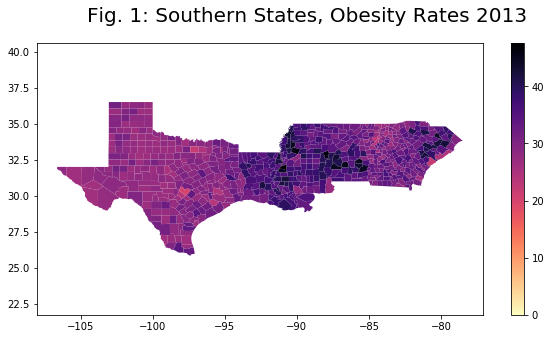

In [35]:
fig, ax = plt.subplots(figsize = (10,5))

deep_south.plot(ax = ax,
              edgecolor = '', 
              cmap = 'magma_r',
              vmin = 0, vmax = geo_df.obese_13.max(),
              legend = True,
              column = 'obese_13')


plt.suptitle('Fig. 1: Southern States, Obesity Rates 2013', fontsize = 20)

plt.axis('equal')
plt.show()

Fig. 1 shows the obesity rates in the Southern states. Parts of Louisiana and Mississippi suffer from some of the highest abortion rates in the region.

In [28]:
NE_states = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT']

new_england = geo_df[geo_df.State.isin(NE_states)]

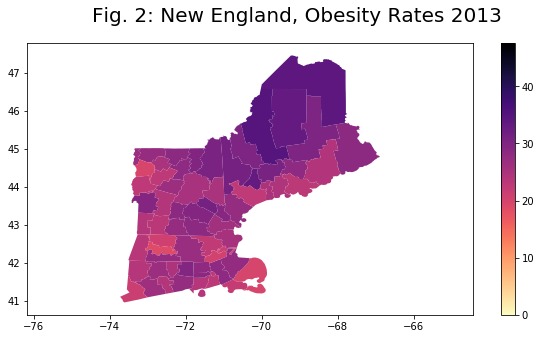

In [37]:
fig, ax = plt.subplots(figsize = (10,5))

new_england.plot(ax = ax,
              edgecolor = '', 
              cmap = 'magma_r',
              vmin = 0, vmax = geo_df.obese_13.max(),
              legend = True,
              column = 'obese_13')

plt.suptitle('Fig. 2: New England, Obesity Rates 2013', fontsize = 20)

plt.axis('equal')
plt.show()

Fig. 2 shows obesity rates in the New England region. Visually, the average of this region is lower than the average of the Southern states.

# 2. Fast food expenditure and obesity

In this section, I explore the relationship between real income and health. I suspect that low income regions suffer from the highest rates of obesity across the nation. 

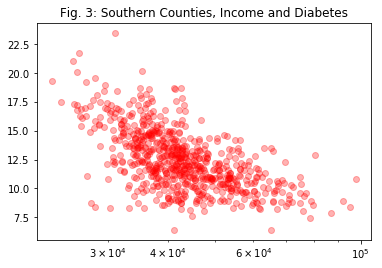

In [38]:
# Hypothesis: Clear negative relationships between household income and diabetes rate

plt.scatter(deep_south.income, deep_south.diabetes_13, c = 'r', alpha = 0.3)
plt.title('Fig. 3: Southern Counties, Income and Diabetes', fontsize = 12)
plt.xscale('log')

Fig. 3 shows the negative relationship between income and obesity rates in the examined counties. On average, richer counties likely spend a smaller proportion of their income on fast food than poorer counties. 

In [39]:
# Data aggregated by state

grouped = df.groupby(['State']).mean()

grouped = grouped.sort_values(by = ['fastspend_12'], ascending = False)

Here, I aggregate real fast food spending by state to create Figure 4.

In [40]:
# Purchasing power differs from state to state, of course. So we normalize based on the BEA's regional price parity index

rpp_df = pd.read_excel(file_path + '\\rpp0518.xlsx', sheet_name = 'Table 3')

In [41]:
rpp_df.columns = ['state_full', 'all_items', 'goods', 'rent', 'other']

In [42]:
rpp_df = rpp_df[4:55]

In [43]:
# They say 'taxation without representation' but I have included D.C. in my analysis as well

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

rpp_df['State'] = states

In [44]:
rpp_df.head(3)

,state_full,all_items,goods,rent,other,State
4,Alabama,86.6,96.2,63.2,93.3,AL
5,Alaska,105.4,101.1,137.5,96.6,AK
6,Arizona,95.9,97.4,91.8,97.2,AZ


In [45]:
grouped = grouped.merge(rpp_df, on = 'State')

In [46]:
# pct_ffs = percentage of real income spent on fast food
# delta_ffs = the difference between a state's pct_ffs and the mean

grouped['real_fastspend_12'] = grouped.fastspend_12/grouped.goods*100
grouped['real_income'] = grouped.income/grouped.goods*100

grouped['pct_ffs'] = grouped['real_fastspend_12']/grouped['real_income']
grouped['delta_ffs'] = grouped.pct_ffs - grouped.pct_ffs.mean()

grouped = grouped.sort_values(by = ['delta_ffs'])

In [48]:
grouped.set_index('State', inplace = True)

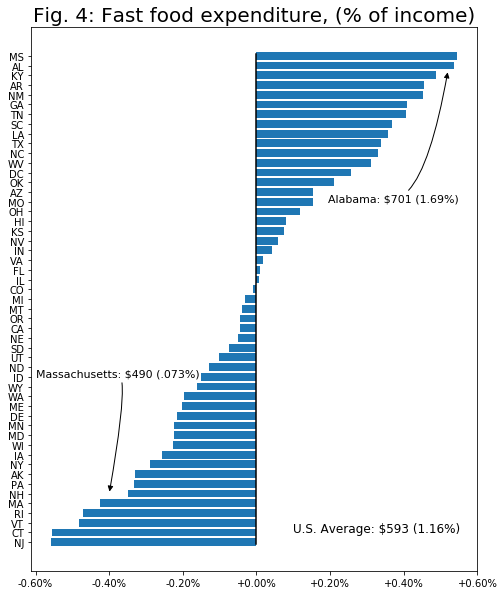

In [49]:
fig, ax = plt.subplots(figsize = (8,10))

ax.set_title('Fig. 4: Fast food expenditure, (% of income)', fontsize = 20)

ax.barh(grouped.index, grouped.delta_ffs)

ax.axvline(0, color = 'k', ymin = 0.05, ymax = 0.95)

vals = ax.get_xticks()
ax.set_xticklabels(['{:+,.2%}'.format(x) for x in vals])

ax.annotate(
    'U.S. Average: $593 (1.16%)',
    xy = (0.001, 1),
    fontsize = 12
)

ax.annotate(
    'Alabama: $701 (1.69%)', 
    xy=(0.0052,48.5), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(0.0055, 35), # This is about where the text is
    horizontalalignment="right", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=80",
        "color": "black"
    },
    fontsize=11,
)

ax.annotate(
    'Massachusetts: $490 (.073%)', 
    xy=(-0.004,5), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(-0.006, 17), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=80",
        "color": "black"
    },
    fontsize=11,
)


plt.show()

In [50]:
geo_df.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'FIPS', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'pop_census', 'pop_16',
       'fast_09', 'fast_14', 'rest_09', 'rest_14', 'fastspend_09',
       'fastspend_12', 'restspend_09', 'restspend_12', 'State', 'County',
       'diabetes_08', 'diabetes_13', 'obese_08', 'obese_13', 'hsactive_15',
       'income', 'poverty_rate', 'child_poverty'],
      dtype='object')

In [51]:
geo_df['pct_ffs'] = geo_df['fastspend_12']/geo_df['income']

In [52]:
states_48 = ["AL", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", 
             "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
             "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
             "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
             "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

states_AK = ['AK']

states_HI = ['HI']

In [53]:
geo_48 = geo_df[geo_df.State.isin(states_48)]

In [54]:
geo_AK = geo_df[geo_df.State.isin(states_AK)]
geo_HI = geo_df[geo_df.State.isin(states_HI)]

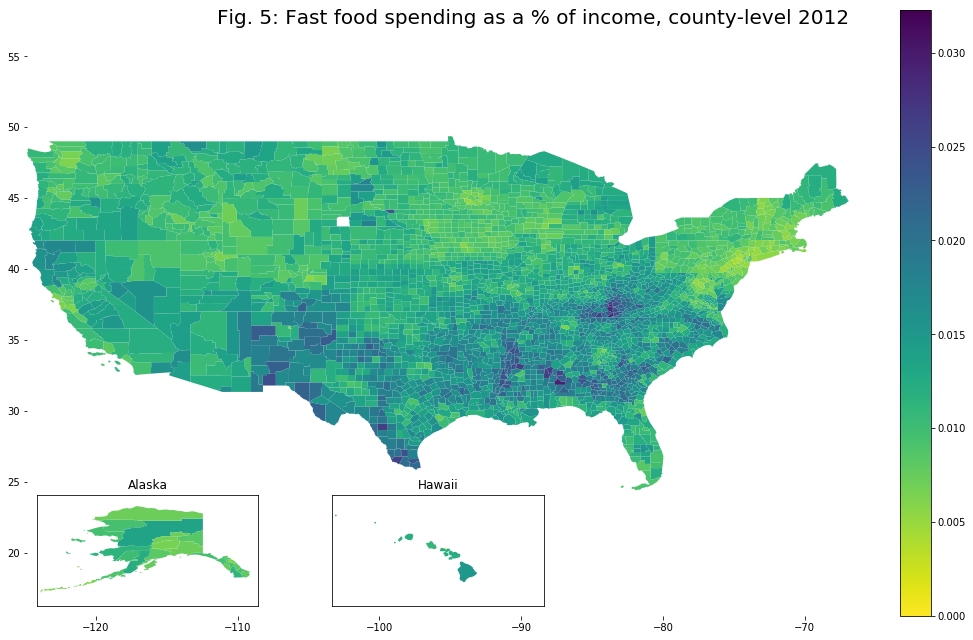

In [107]:
fig, ax = plt.subplots(figsize = (15,9))
plt.tight_layout()

############################################## continental main plot ##############################################
geo_48.plot(ax = ax,
              edgecolor = '', 
              cmap = 'viridis_r',
              vmin = 0, vmax = 1.1*geo_df.pct_ffs.max(),
              legend = True,
              column = 'pct_ffs')

plt.axis('equal')
minx, miny, maxx, maxy = geo_48.total_bounds
ax.set_xlim(minx,maxx)
ax.set_ylim(miny,maxy)

############################################## alaska sub plot ##############################################

axins = zoomed_inset_axes(ax,
                          0.3,
                          loc=3,
                          borderpad=1)

geo_AK.plot(ax = axins,
            edgecolor = '', 
            cmap = 'viridis_r',
            vmin = 0, vmax = 1.1*geo_df.pct_ffs.max(),
            legend = False,
            column = 'pct_ffs')

x1, x2, y1, y2 = -180, -128, 48, 74
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.set_title("Alaska")

############################################## hawaii sub plot ##############################################

axins2 = zoomed_inset_axes(ax,
                          1,
                          loc=8,
                          borderpad=1)

geo_HI.plot(ax = axins2,
            edgecolor = '', 
            cmap = 'viridis_r',
            vmin = 0, vmax = 1.1*geo_df.pct_ffs.max(),
            legend = False,
            column = 'pct_ffs')

x1, x2, y1, y2 = -165, -150, 17.2, 25
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)

axins2.set_title("Hawaii")

############################################## cosmetics ##############################################

plt.suptitle('Fig. 5: Fast food spending as a % of income, county-level 2012', fontsize = 20)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

axins.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')
axins2.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')



plt.show()

In [59]:
geo_df.pct_ffs.corr(geo_df.diabetes_13)

0.616192722024055

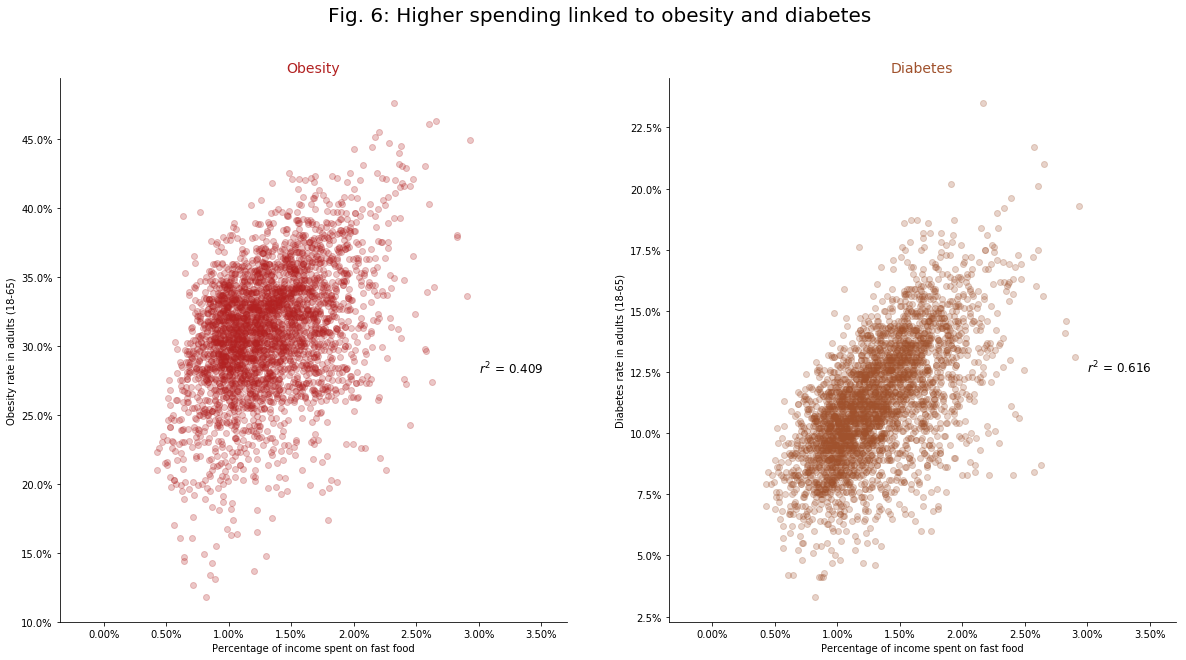

In [60]:
fig, ax = plt.subplots(1, 2, sharex = True, figsize = (20,10))

plt.suptitle('Fig. 6: Higher spending linked to obesity and diabetes', fontsize = 20)

###################################### plot ######################################

ax[0].scatter(geo_df.pct_ffs, geo_df.obese_13, c = 'firebrick', alpha = 0.25)
ax[1].scatter(geo_df.pct_ffs, geo_df.diabetes_13, c = 'sienna', alpha = 0.25)

###################################### title and labels ######################################

ax[0].set_title('Obesity', color = 'firebrick', fontsize = 14)
ax[1].set_title('Diabetes', color = 'sienna', fontsize = 14)

ax[0].set_xlabel('Percentage of income spent on fast food')
ax[1].set_xlabel('Percentage of income spent on fast food')

ax[0].set_ylabel('Obesity rate in adults (18-65)')
ax[1].set_ylabel('Diabetes rate in adults (18-65)')

###################################### spines ######################################

ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)

ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)


###################################### r^2 and format axis ticks ######################################
xvals = ax[0].get_xticks()
ax[0].set_xticklabels(['{:,.2%}'.format(x) for x in xvals])

yvals = ax[0].get_yticks()*0.01
ax[0].set_yticklabels(['{:,.1%}'.format(x) for x in yvals])

ax[0].text(0.03,28,
    '$r^2$ = 0.409',
    fontsize = 12
)
xvals = ax[1].get_xticks()
ax[1].set_xticklabels(['{:,.2%}'.format(x) for x in xvals])

yvals = ax[1].get_yticks()*0.01
ax[1].set_yticklabels(['{:,.1%}'.format(x) for x in yvals])

ax[1].text(0.03,12.5,
    '$r^2$ = 0.616',
    fontsize = 12
)

plt.show()

Fig. 6 is an analysis of 3,000+ counties that shows: higher fast food spending %-wise leads to higher obesity and diabetic rates. 

# 3. Fast food concentration and Health

In this section, I explore the relationship between fast food concentration and health. I plot the concentration per 1,000 people versus obesity and diabetes to see if theres any relationship.

In [64]:
geo_df.pop_16 = geo_df.pop_16.str.replace(',', '').astype(float)

In [65]:
geo_df['ff_density'] = geo_df.fast_14/geo_df.pop_16*1000

In [66]:
geo_df['ff_density'].tail()

3135    0.706286
3136    0.511967
3137    0.951348
3138    0.762777
3139    0.419432
Name: ff_density, dtype: float64

In [67]:
geo_df.ff_density = geo_df.ff_density.replace(0, np.nan)

In [68]:
print(geo_df.ff_density.corr(geo_df.diabetes_13));print(geo_df.ff_density.corr(geo_df.obese_13))

-0.16871586502592906
-0.2321868258086288


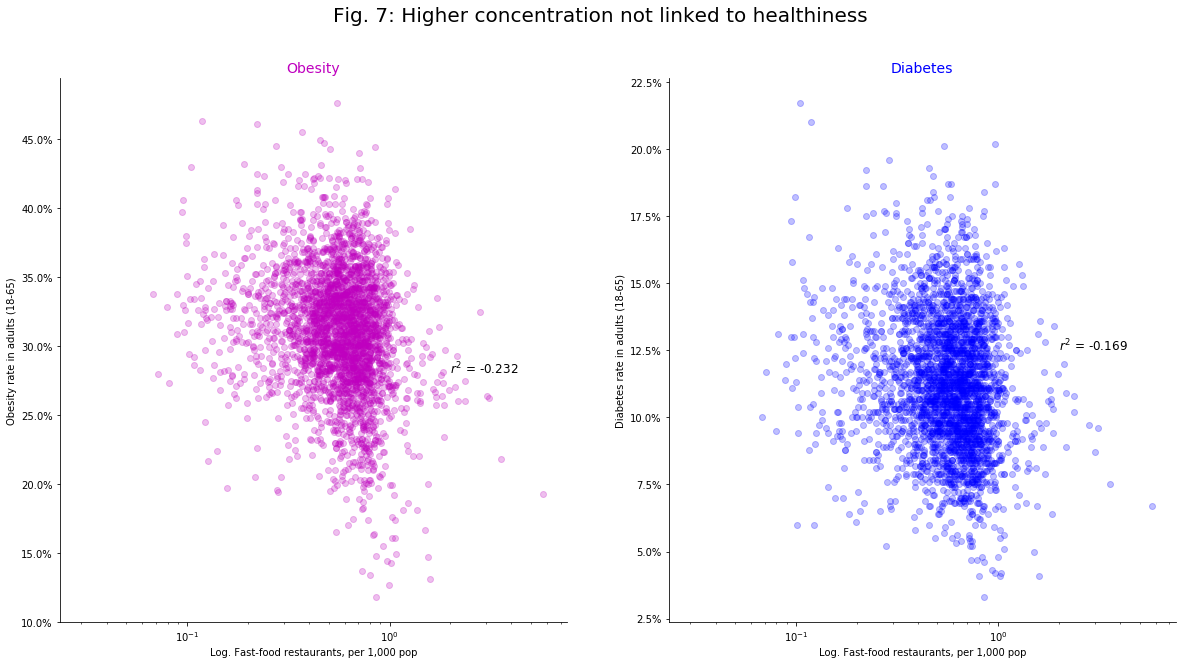

In [70]:
fig, ax = plt.subplots(1, 2, sharex = True, figsize = (20,10))

plt.suptitle('Fig. 7: Higher concentration not linked to healthiness', fontsize = 20)

ax[0].set_title('Obesity', color = 'm', fontsize = 14)
ax[1].set_title('Diabetes', color = 'b', fontsize = 14)

ax[0].set_xlabel('Log. Fast-food restaurants, per 1,000 pop')
ax[1].set_xlabel('Log. Fast-food restaurants, per 1,000 pop')

ax[0].scatter(geo_df.ff_density, geo_df.obese_13, c = 'm', alpha = 0.25)
ax[1].scatter(geo_df.ff_density, geo_df.diabetes_13, c = 'b', alpha = 0.25)

ax[0].set_ylabel('Obesity rate in adults (18-65)')
ax[1].set_ylabel('Diabetes rate in adults (18-65)')

ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)

ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)

xvals = ax[0].get_xticks()
ax[0].set_xticklabels(['{:,.2%}'.format(x) for x in xvals])

yvals = ax[0].get_yticks()*0.01
ax[0].set_yticklabels(['{:,.1%}'.format(x) for x in yvals])

ax[0].text(2,28,
    '$r^2$ = -0.232',
    fontsize = 12
)

xvals = ax[1].get_xticks()
ax[1].set_xticklabels(['{:,.2}'.format(x) for x in xvals])

yvals = ax[1].get_yticks()*0.01
ax[1].set_yticklabels(['{:,.1%}'.format(x) for x in yvals])

ax[1].text(2,12.5,
    '$r^2$ = -0.169',
    fontsize = 12
)

plt.xscale('log')
plt.show()

What is likely happening in Fig 7. is that places with higher concentrations of fast food restaurants are cities. Metro populations, on average, tend to exhibit lower obesity and diabetic rates, which may not bear any relationship to the proximity of these fast food restaurants. 

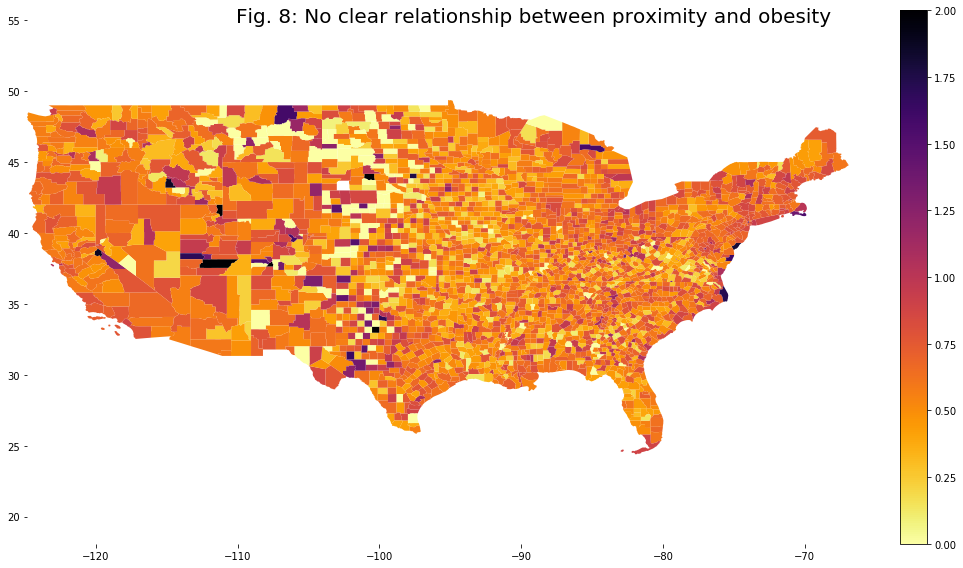

In [101]:
fig, ax = plt.subplots(figsize = (15,8))
plt.tight_layout()

geo_df['log_density'] = np.log(geo_df.ff_density)

############################################## continental main plot ##############################################
geo_df.plot(ax = ax,
              edgecolor = '', 
              cmap = 'inferno_r',
              vmin = 0, vmax = 2,
              legend = True,
              column = 'ff_density')

plt.axis('equal')
minx, miny, maxx, maxy = geo_48.total_bounds
ax.set_xlim(minx,maxx)
ax.set_ylim(miny,maxy)

plt.suptitle('Fig. 8: No clear relationship between proximity and obesity', fontsize = 20)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

plt.show()

# 4. Other factors worth exploring (scaling up)

In [206]:
sheet_list = ['ASSISTANCE', 'PRICES_TAXES', 'HEALTH', 'SOCIOECONOMIC', 'STORES']

df = []

for sheet in sheet_list:
    data = pd.read_excel('https://www.ers.usda.gov/webdocs/DataFiles/48731/DataDownload.xls?v=0', sheet_name = sheet)
    df.append(data)
    
df = pd.concat(df, axis = 1)

df = df.loc[:,~df.columns.duplicated()]
df = df.set_index('FIPS')

In [207]:
df_big = pd.merge(df, df_pop, on = 'FIPS')

In [233]:
df_big = df_big.replace(0, np.nan)

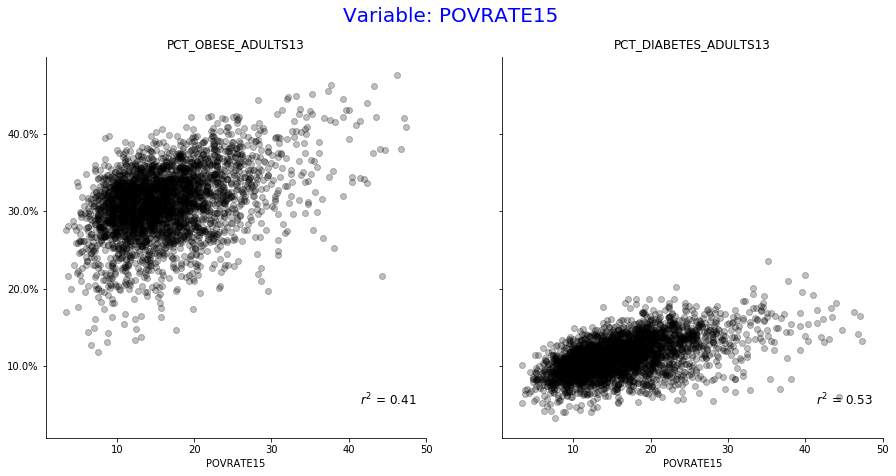

In [399]:
### I am writing a function that allows you to input any variable, and outputs a graph and r^2 number ###

import matplotlib.ticker as ticker

y_list = ['PCT_OBESE_ADULTS13', 'PCT_DIABETES_ADULTS13']

def plot(var):
    
    fig, axes = plt.subplots(1,2, sharex = True, sharey = True, figsize = (15,7))
    
    plt.suptitle('Variable: ' + var, color = 'b', fontsize = 20)
    
    for ax, y in zip(axes.flatten(), y_list): 
        
        ax.scatter(df_big[var], df_big[y], c = 'k', alpha = '0.25')
        
        ax.set_title(y, color = 'k', fontsize = 12, loc = 'center', pad = 10)
        
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 100))
        
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        
        ax.set_xlabel(var)
        
        ax.text(0.9, 0.1,
        '$r^2$ = ' + str(round(df_big[var].corr(df_big[y]),2)),
        ha='center', va='center', transform=ax.transAxes,
        fontsize = 12
        )

plot('POVRATE15')

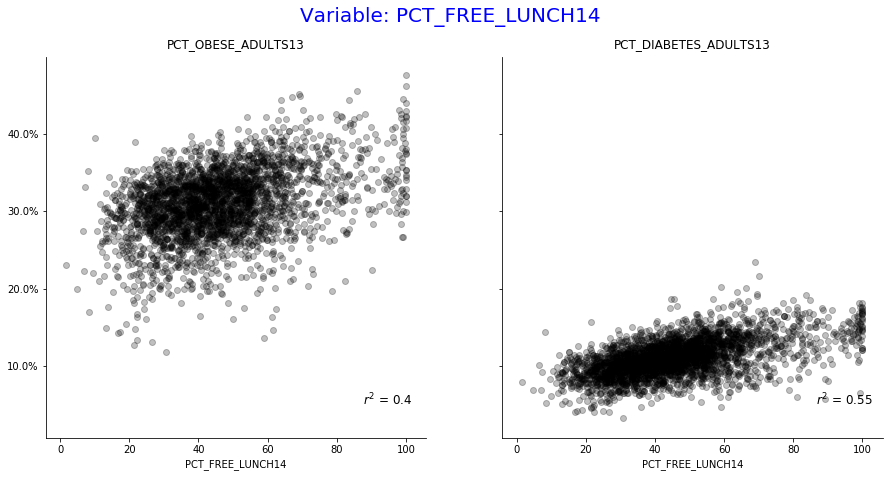

In [400]:
plot('PCT_FREE_LUNCH14') # pct of students on free lunch programs

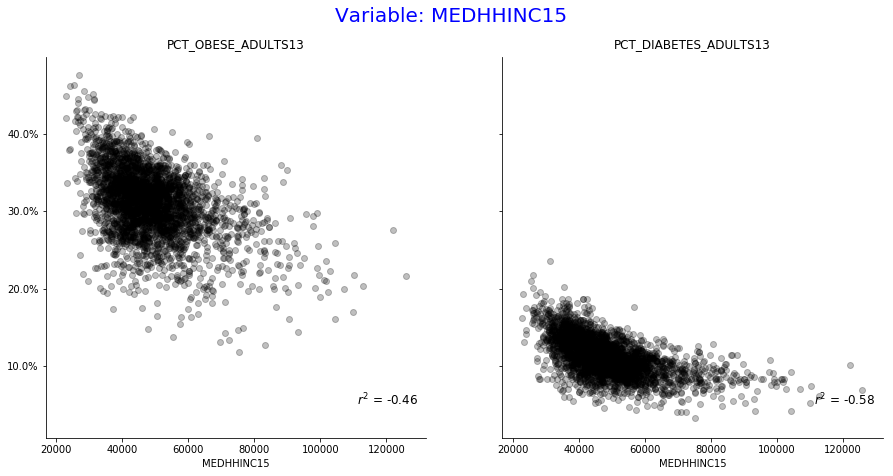

In [402]:
plot('MEDHHINC15') # median household income, 2015

In [403]:
variables = pd.read_excel('https://www.ers.usda.gov/webdocs/DataFiles/48731/DataDownload.xls?v=0', sheet_name = 'Variable List')

In [404]:
variables.head() # exhaustive list of variable list 

,Category Name,Category Code,Subcategory Name,Variable Name,Variable Code,Geography,Units
0,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store, 2010",LACCESS_POP10,CNTY10,Count
1,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store, 2015",LACCESS_POP15,CNTY10,Count
2,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store (% change), 20...",PCH_LACCESS_POP_10_15,CNTY10,% change
3,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store (%), 2010",PCT_LACCESS_POP10,CNTY10,Percent
4,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store (%), 2015",PCT_LACCESS_POP15,CNTY10,Percent
